## Problem Statement

A cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth from the neutral mutations. 
Considering this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

We need to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations based on evidence from text-based clinical literature.

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import time
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import normalize
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import FunctionTransformer
import warnings
warnings.filterwarnings("ignore")

#### Loading the data:

In [2]:
data=pd.read_csv('training_variants')
print('Total gene variations:',data.shape[0])
print('Total features:',data.shape[1])
print('Features:',data.columns.values)
data.head()

Total gene variations: 3321
Total features: 4
Features: ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
text_data=pd.read_csv('training_text',sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Total gene variations:',text_data.shape[0])
print('Total features:',text_data.shape[1])
print('Features:',text_data.columns.values)
text_data.head()

Total gene variations: 3321
Total features: 2
Features: ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


### Preprocessing of Text

In [4]:
#stop words
stop_words=set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        text_data[column][index] = string

In [5]:
start_time = time.perf_counter()
for index, row in text_data.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.perf_counter() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 85.5752278 seconds


In [6]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, text_data,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [7]:
result[result['ID']==1277]

,ID,Gene,Variation,Class,TEXT
1277,1277,ARID5B,Truncating Mutations,1,NaN


In [8]:
result.loc[result['TEXT'].isnull(),'TEXT']=result['Gene'] +' '+ result['Variation']

In [9]:
result[result['ID']==1277]

,ID,Gene,Variation,Class,TEXT
1277,1277,ARID5B,Truncating Mutations,1,ARID5B Truncating Mutations


### Train, CV and Test Datasets

In [10]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [11]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


#### Distribution of yi's in all splits:

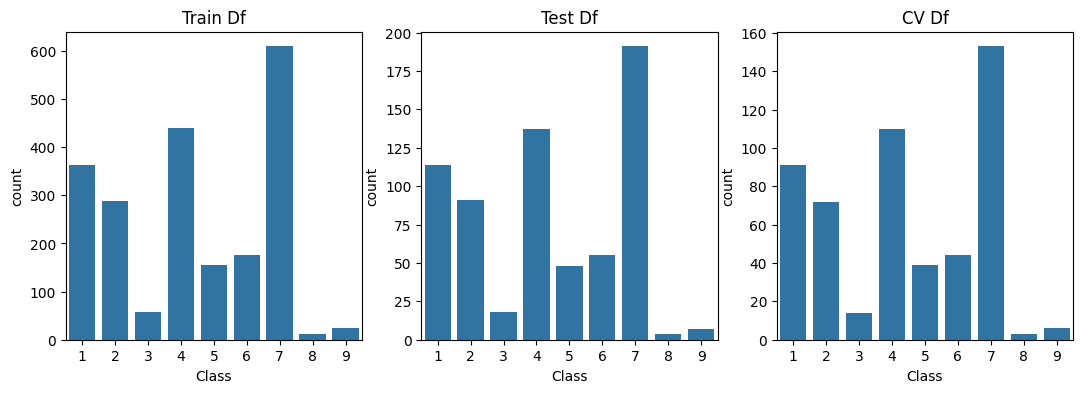

In [12]:
fig, axes = plt.subplots(1,3,figsize=(13, 4))

sns.barplot(train_df['Class'].value_counts(),ax=axes[0])
sns.barplot(test_df['Class'].value_counts(),ax=axes[1])
sns.barplot(cv_df['Class'].value_counts(),ax=axes[2])
axes[0].set_title('Train Df')
axes[1].set_title('Test Df')
axes[2].set_title('CV Df')
plt.show()

Distribution of Train, Test and CV data are roughly same and each of imbalanced data.

### Random Model

In [13]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T) #recall
    B =(C/C.sum(axis=0)) #precision
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [14]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

cv_predicted_y = np.zeros((cv_data_len,9))
np.random.seed(42)
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    
test_predicted_y=np.zeros((test_data_len,9))
np.random.seed(42)
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y))
print("Log loss on Cross Validation Data using Random Model",log_loss(y_test,test_predicted_y))

Log loss on Cross Validation Data using Random Model 2.466622224168529
Log loss on Cross Validation Data using Random Model 2.525890071691523


-------------------- Confusion matrix --------------------


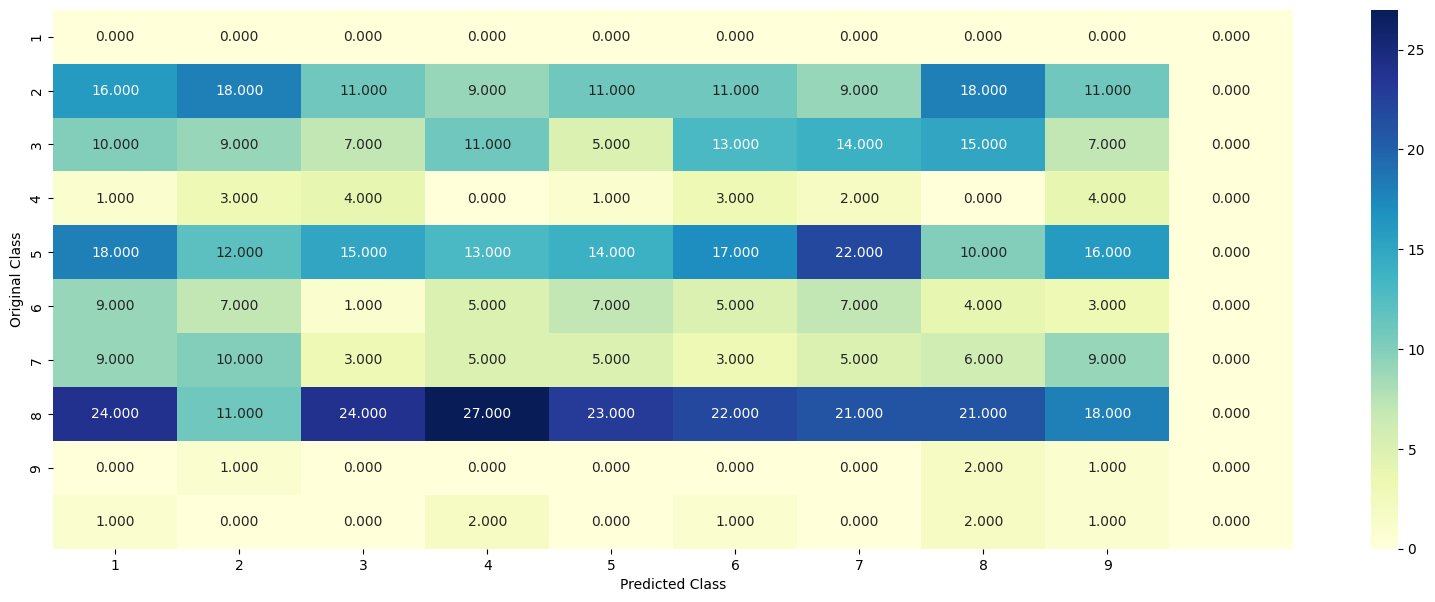

-------------------- Precision matrix (Columm Sum=1) --------------------


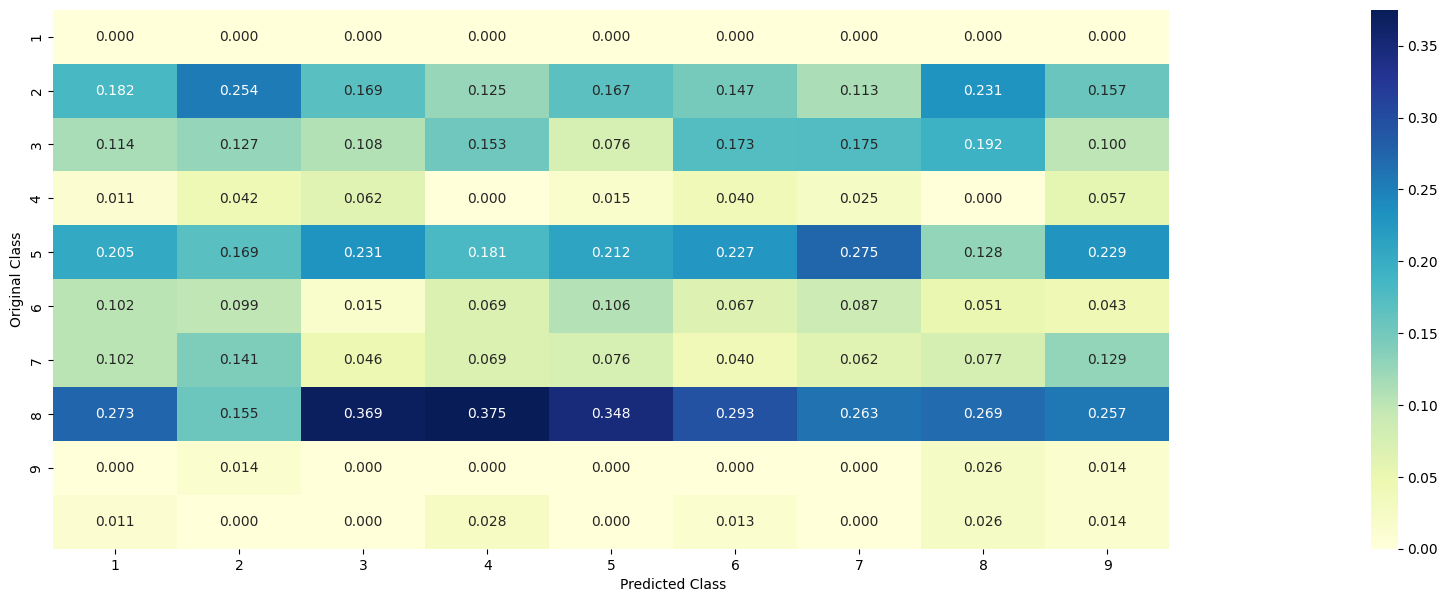

-------------------- Recall matrix (Row sum=1) --------------------


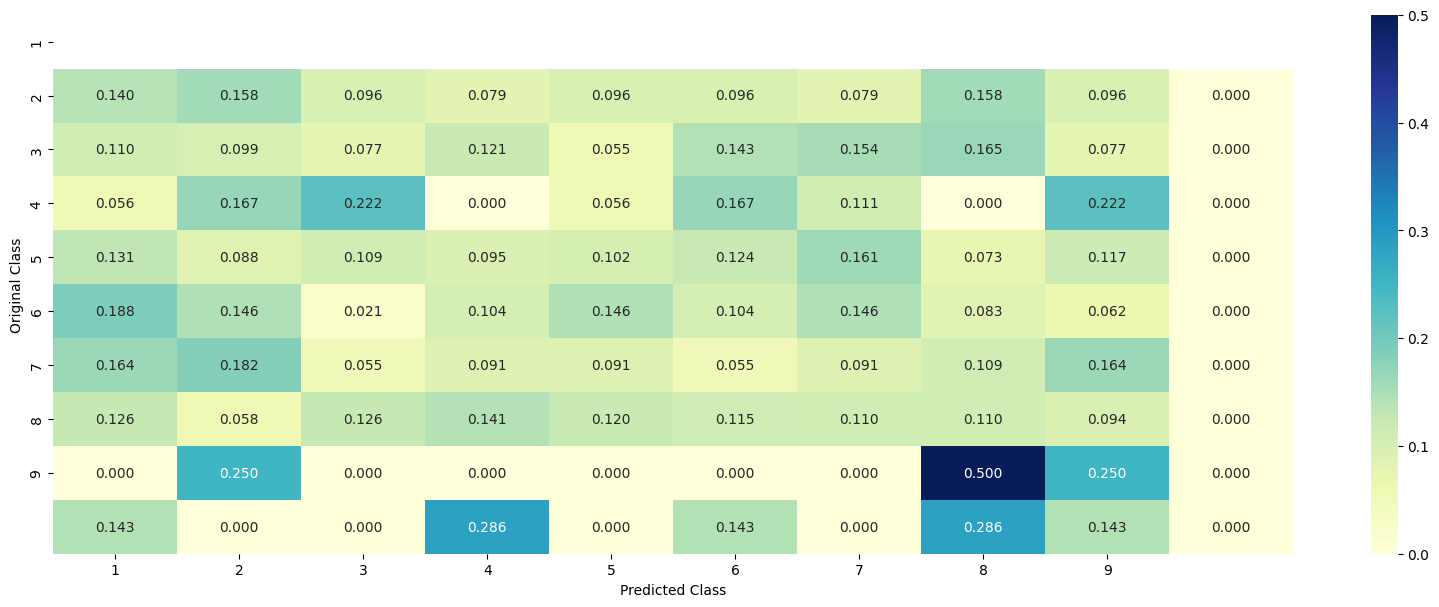

In [15]:
predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test,predicted_y)

### Univariate Analysis of Gene Feature

In [16]:
print('Unique Gene counts:',train_df['Gene'].value_counts().shape[0])
train_df['Gene'].value_counts().head(10)

Unique Gene counts: 239


Gene
BRCA1     168
TP53       97
EGFR       92
PTEN       80
BRCA2      76
BRAF       61
KIT        60
ALK        43
ERBB2      42
PIK3CA     36
Name: count, dtype: int64

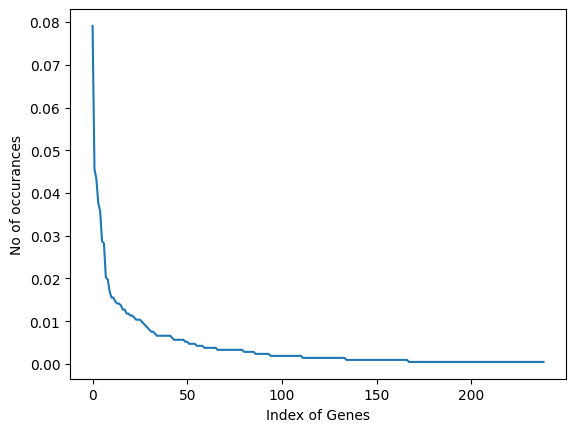

In [17]:
h=sum(train_df['Gene'].value_counts().values)
s=(train_df['Gene'].value_counts().values)/h

plt.plot(s)
plt.xlabel('Index of Genes')
plt.ylabel('No of occurances')
plt.show()

In [18]:
train_df['Gene'].value_counts().values

array([168,  97,  92,  80,  76,  61,  60,  43,  42,  36,  33,  33,  31,
        30,  30,  29,  27,  27,  25,  25,  24,  24,  23,  22,  22,  22,
        21,  20,  19,  18,  17,  16,  16,  15,  14,  14,  14,  14,  14,
        14,  14,  14,  13,  12,  12,  12,  12,  12,  12,  11,  11,  10,
        10,  10,  10,   9,   9,   9,   9,   8,   8,   8,   8,   8,   8,
         8,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
         7,   7,   6,   6,   6,   6,   6,   6,   5,   5,   5,   5,   5,
         5,   5,   5,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   4,   4,   4,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   

In [19]:
#Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    
    gv_dict = dict()
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [20]:
###---response coding
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
train_gene_feature_responseCoding = (train_gene_feature_responseCoding.T / train_gene_feature_responseCoding.sum(axis=1)).T

# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
test_gene_feature_responseCoding = (test_gene_feature_responseCoding.T / test_gene_feature_responseCoding.sum(axis=1)).T

# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))
cv_gene_feature_responseCoding = (cv_gene_feature_responseCoding.T / cv_gene_feature_responseCoding.sum(axis=1)).T

In [21]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])
train_gene_feature_onehotCoding = normalize(train_gene_feature_onehotCoding, axis=0)
test_gene_feature_onehotCoding = normalize(test_gene_feature_onehotCoding, axis=0)
cv_gene_feature_onehotCoding = normalize(cv_gene_feature_onehotCoding, axis=0)

In [22]:
gene_vectorizer.get_feature_names_out()

array(['abl1', 'acvr1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc',
       'ar', 'araf', 'arid1b', 'arid2', 'arid5b', 'asxl1', 'asxl2', 'atm',
       'atr', 'atrx', 'aurka', 'aurkb', 'axl', 'b2m', 'bap1', 'bard1',
       'bcl10', 'bcl2l11', 'bcor', 'braf', 'brca1', 'brca2', 'brd4',
       'brip1', 'btk', 'card11', 'carm1', 'casp8', 'cbl', 'ccnd1',
       'ccnd2', 'ccnd3', 'ccne1', 'cdh1', 'cdk12', 'cdk4', 'cdkn1a',
       'cdkn1b', 'cdkn2a', 'cdkn2b', 'cdkn2c', 'chek2', 'cic', 'crebbp',
       'ctcf', 'ctnnb1', 'ddr2', 'dicer1', 'dnmt3a', 'dnmt3b', 'dusp4',
       'egfr', 'eif1ax', 'elf3', 'ep300', 'epas1', 'epcam', 'erbb2',
       'erbb3', 'erbb4', 'ercc2', 'ercc3', 'ercc4', 'errfi1', 'esr1',
       'etv1', 'etv6', 'ewsr1', 'ezh2', 'fam58a', 'fanca', 'fancc',
       'fat1', 'fbxw7', 'fgf19', 'fgf3', 'fgf4', 'fgfr1', 'fgfr2',
       'fgfr3', 'fgfr4', 'flt1', 'flt3', 'foxa1', 'foxl2', 'foxp1',
       'gata3', 'gli1', 'gnas', 'h3f3a', 'hist1h1c', 'hla', 'hnf1a',
       'hras', 'idh1', 

In [23]:
##to check how good is the feature gene for predicting yi with one hot encoding

alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y))

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))


For values of alpha =  1e-05 The log loss is: 1.1730091590110499
For values of alpha =  0.0001 The log loss is: 1.176701934587853
For values of alpha =  0.001 The log loss is: 1.1813996878404132
For values of alpha =  0.01 The log loss is: 1.2172655236329746
For values of alpha =  0.1 The log loss is: 1.2896346712057927
For values of alpha =  1 The log loss is: 1.3009196153114149
For values of best alpha =  1e-05 The train log loss is: 0.9906278711474509
For values of best alpha =  1e-05 The cross validation log loss is: 1.1730091590110499
For values of best alpha =  1e-05 The test log loss is: 1.2062333365637359


In [24]:
##to check how good is the feature gene for predicting yi with response coding

alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_gene_feature_responseCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_responseCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_responseCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y))

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_gene_feature_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_responseCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_gene_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_gene_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

For values of alpha =  1e-05 The log loss is: 1.2228936612706816
For values of alpha =  0.0001 The log loss is: 1.2458894102144595
For values of alpha =  0.001 The log loss is: 1.3076075185735525
For values of alpha =  0.01 The log loss is: 1.343649107097072
For values of alpha =  0.1 The log loss is: 1.3521204509653795
For values of alpha =  1 The log loss is: 1.3475457489125904
For values of best alpha =  1e-05 The train log loss is: 1.1726684804652392
For values of best alpha =  1e-05 The cross validation log loss is: 1.2228936612706816
For values of best alpha =  1e-05 The test log loss is: 1.2787209987283688


#### with clear comparasion of log loss among cross and test data are close to eachother which implies Gene feature is stable.

### Univariate Analysis of Variation Feature

In [25]:
print('Unique Variation counts:',train_df['Variation'].value_counts().shape[0])
train_df['Variation'].value_counts().head(10)

Unique Variation counts: 1926


Variation
Deletion                57
Truncating Mutations    56
Amplification           45
Fusions                 21
Overexpression           5
E17K                     3
Q61L                     3
P130S                    2
Q61R                     2
Y64A                     2
Name: count, dtype: int64

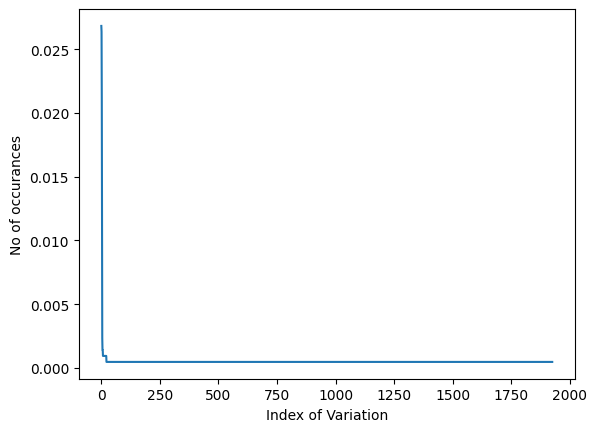

In [26]:
h=sum(train_df['Variation'].value_counts().values)
s=(train_df['Variation'].value_counts().values)/h

plt.plot(s)
plt.xlabel('Index of Variation')
plt.ylabel('No of occurances')
plt.show()

In [27]:
###---response coding
alpha=1
# train variation feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
train_variation_feature_responseCoding=(train_variation_feature_responseCoding.T/train_variation_feature_responseCoding.sum(axis=1)).T
# test variation feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
test_variation_feature_responseCoding = (test_variation_feature_responseCoding.T/test_variation_feature_responseCoding.sum(axis=1)).T
# cross validation variation feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))
cv_variation_feature_responseCoding=(cv_variation_feature_responseCoding.T/cv_variation_feature_responseCoding.sum(axis=1)).T

In [28]:
# one-hot encoding of Variation feature.
variation_vectorizer = CountVectorizer()
#train variation feature
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
#test variation feature
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
#cv variation feature
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])
train_variation_feature_onehotCoding = normalize(train_variation_feature_onehotCoding,axis=0)
test_variation_feature_onehotCoding = normalize(test_variation_feature_onehotCoding,axis=0)
cv_variation_feature_onehotCoding = normalize(cv_variation_feature_onehotCoding,axis=0)

In [29]:
variation_vectorizer.get_feature_names_out()

array(['126', '17', '19', ..., 'yy1', 'zc3h7b', 'znf198'], dtype=object)

In [30]:
##to check how good is the feature variation for predicting yi with one hot encoding

alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y))

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

For values of alpha =  1e-05 The log loss is: 1.7278827071605132
For values of alpha =  0.0001 The log loss is: 1.7201309585252722
For values of alpha =  0.001 The log loss is: 1.7177748360022533
For values of alpha =  0.01 The log loss is: 1.7203896064529236
For values of alpha =  0.1 The log loss is: 1.7369839714708124
For values of alpha =  1 The log loss is: 1.738663185788063
For values of best alpha =  0.001 The train log loss is: 0.45326986403776093
For values of best alpha =  0.001 The cross validation log loss is: 1.7177748360022533
For values of best alpha =  0.001 The test log loss is: 1.6852029092164327


In [31]:
##to check how good is the feature gene for predicting yi with response coding

alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_variation_feature_responseCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_responseCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_responseCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y))

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_variation_feature_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_responseCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_variation_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_variation_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

For values of alpha =  1e-05 The log loss is: 2.0025920215520983
For values of alpha =  0.0001 The log loss is: 1.9199469267966947
For values of alpha =  0.001 The log loss is: 1.883677296178837
For values of alpha =  0.01 The log loss is: 1.8203403909676659
For values of alpha =  0.1 The log loss is: 1.813791028636776
For values of alpha =  1 The log loss is: 1.805236702208028
For values of best alpha =  1 The train log loss is: 0.968726039707345
For values of best alpha =  1 The cross validation log loss is: 1.805236702208028
For values of best alpha =  1 The test log loss is: 1.7895218468720244


#### with clear comparasion of log loss among cross and test data are almost close to eachother which implies Variation feature is stable.

### Univariate Analysis of TEXT Feature

In [32]:
import math

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [33]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names_out()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52999


In [34]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary


dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)

confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [35]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [36]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [37]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [38]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [39]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({np.int64(3): 5250, np.int64(4): 3442, np.int64(5): 2934, np.int64(6): 2659, np.int64(7): 2017, np.int64(8): 1993, np.int64(9): 1913, np.int64(10): 1421, np.int64(11): 1174, np.int64(12): 1138, np.int64(13): 1021, np.int64(14): 922, np.int64(15): 856, np.int64(16): 795, np.int64(18): 757, np.int64(20): 590, np.int64(22): 586, np.int64(19): 584, np.int64(17): 531, np.int64(21): 493, np.int64(24): 491, np.int64(26): 392, np.int64(27): 371, np.int64(23): 370, np.int64(41): 364, np.int64(33): 353, np.int64(29): 350, np.int64(30): 339, np.int64(28): 328, np.int64(25): 323, np.int64(36): 306, np.int64(49): 281, np.int64(31): 275, np.int64(32): 266, np.int64(35): 243, np.int64(38): 229, np.int64(37): 227, np.int64(34): 218, np.int64(40): 211, np.int64(42): 210, np.int64(44): 200, np.int64(39): 200, np.int64(48): 180, np.int64(46): 175, np.int64(45): 172, np.int64(43): 172, np.int64(56): 162, np.int64(52): 153, np.int64(51): 147, np.int64(50): 145, np.int64(54): 144, np.int64(47): 144,

In [40]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y))

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))


For values of alpha =  1e-05 The log loss is: 1.242016122575277
For values of alpha =  0.0001 The log loss is: 1.1421764496395221
For values of alpha =  0.001 The log loss is: 1.12942251238133
For values of alpha =  0.01 The log loss is: 1.238257362159696
For values of alpha =  0.1 The log loss is: 1.4744621740540886
For values of alpha =  1 The log loss is: 1.6500623324077641
For values of best alpha =  0.001 The train log loss is: 0.6604751039135639
For values of best alpha =  0.001 The cross validation log loss is: 1.12942251238133
For values of best alpha =  0.001 The test log loss is: 1.1547733630018284


#### with clear comparasion of log loss among cross and test data are close to eachother which implies Text feature is stable.

## Machine Learning Models

In [41]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [42]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [43]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not

def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names_out())
    fea2_len = len(var_count_vec.get_feature_names_out())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names_out()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names_out()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names_out()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

### Stacking three types of features

In [44]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [45]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55191)
(number of data points * number of features) in test data =  (665, 55191)
(number of data points * number of features) in cross validation data = (532, 55191)


In [46]:

train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [47]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


### Base Line Model

#### 1. Naive Bayes

In [48]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 
    
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))


for alpha = 1e-05
Log Loss : 1.2342964344307372
for alpha = 0.0001
Log Loss : 1.2294444224450745
for alpha = 0.001
Log Loss : 1.2264834863230727
for alpha = 0.1
Log Loss : 1.2460152322123221
for alpha = 1
Log Loss : 1.2557083164091885
for alpha = 10
Log Loss : 1.4108836410244838
for alpha = 100
Log Loss : 1.4336007310110046
for alpha = 1000
Log Loss : 1.3902722133758831
For values of best alpha =  0.001 The train log loss is: 0.8390575673917937
For values of best alpha =  0.001 The cross validation log loss is: 1.2264834863230727
For values of best alpha =  0.001 The test log loss is: 1.3188040568130075


Log Loss : 1.2264834863230727
Number of missclassified point : 0.37781954887218044
-------------------- Confusion matrix --------------------


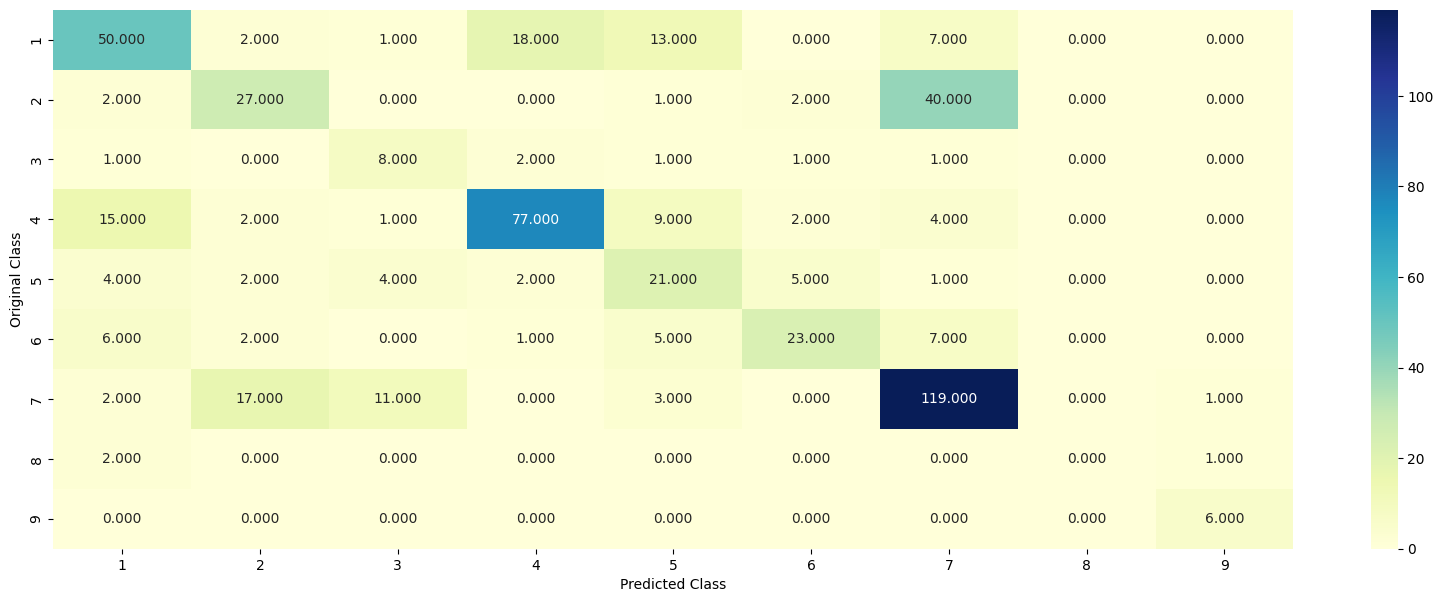

-------------------- Precision matrix (Columm Sum=1) --------------------


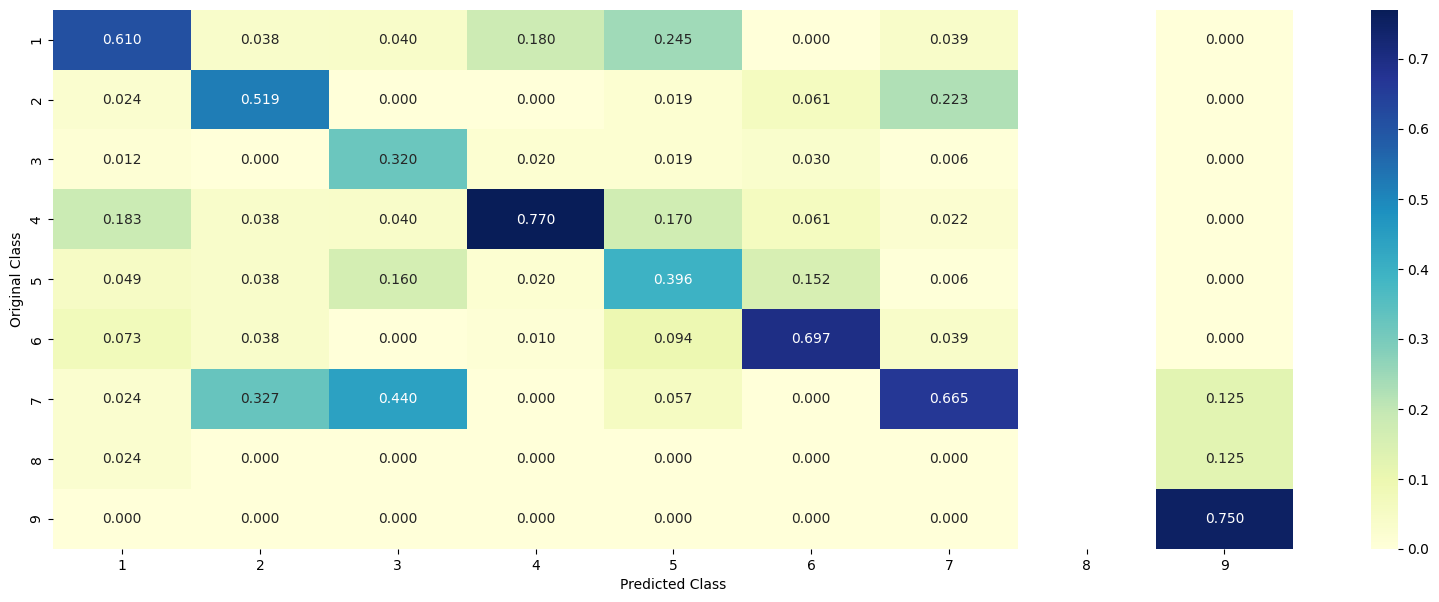

-------------------- Recall matrix (Row sum=1) --------------------


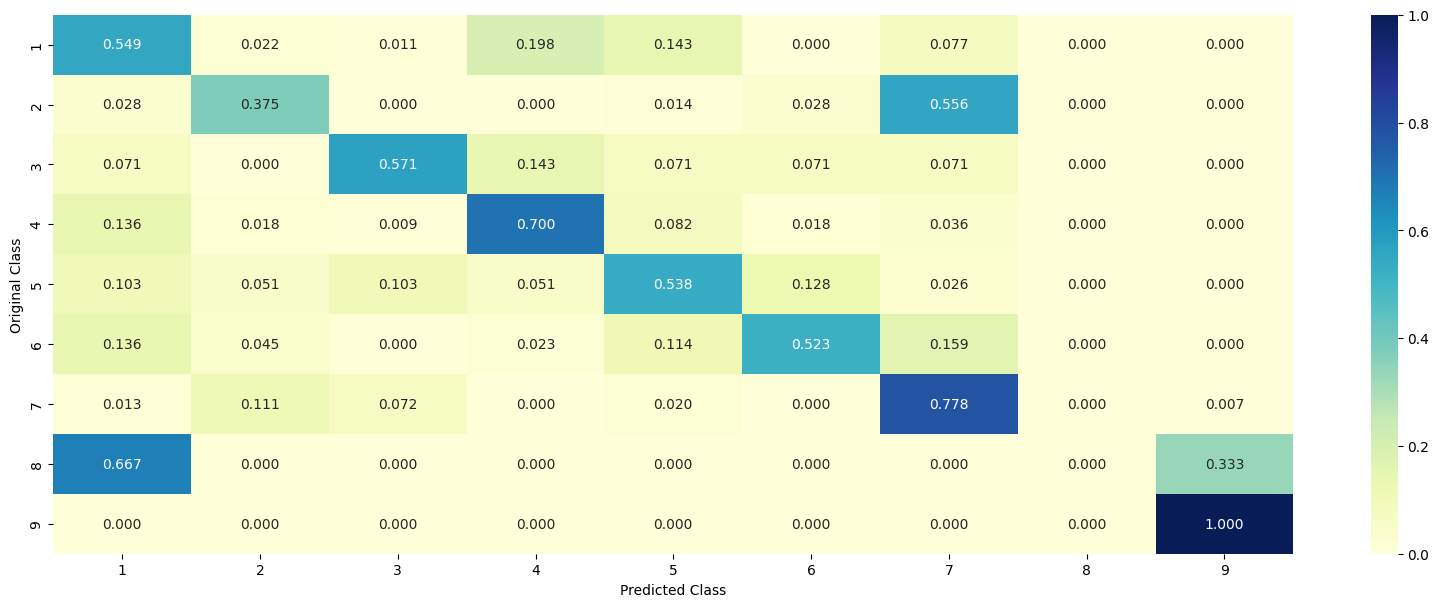

In [49]:
#Testing the model with best hyper paramters
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [50]:
#Feature Importance, Correctly classified point
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

indices=np.argsort(-1*abs(clf.feature_log_prob_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.3842 0.0888 0.0132 0.3173 0.0416 0.0411 0.101  0.0061 0.0068]]
Actual Class : 1
--------------------------------------------------
Out of the top  100  features  0 are present in query point


In [51]:
test_df['TEXT'].iloc[test_point_index]

'abstract mutations tumour suppressor gene tp53 associated nearly half human cancers appear rare 10 feline neoplasms reasons difference presently unclear might related evolutionary divergence p53 functions begin exploring issue developed yeast based functional assay measure transcriptional ability wild type wt mutant feline p53 fe p53 comparison human murine p53 hu p53 mo p53 fe p53 cdna cloned expressed panel yeast reporter strains engineered contain ade2 luciferase gene p53 control via different p53 response elements established wt fe hu mo p53 act transcription factors yeast overlapping dna sequence specificities random mutagenesis phenotypic evaluation fe hu p53 cdnas also performed revealing equal susceptibility deleterious mutations five tumour associated fe p53 mutants exhibited similar impact transactivation capacity partial complete loss compared corresponding hu p53 mutants given high conservation intrinsic functional properties fe p53 studies needed clarify role p53 feline c

In [52]:
test_df['Gene'].iloc[test_point_index]

'TP53'

In [53]:
no_feature

100

In [54]:
clf.feature_log_prob_.shape

(9, 55191)

In [55]:
indices=np.argsort(-1*abs(clf.feature_log_prob_))[predicted_cls-1][:,:no_feature]
indices[0]

array([55142, 55141,    49,    47,    43,    40,    39,    38,    37,
       55172, 55171, 55170, 55169, 24152, 55167, 24150, 55176,    19,
          18,     9,     6,     5, 26243, 26241, 26238, 26234, 24148,
       24147, 26230, 24146, 26260, 55179,    57,    54,    53, 55140,
       55138, 55135, 55134, 55129, 55128, 55127, 55126, 55125, 55156,
       55149, 55146, 24145,    84,    83,    82,    76,    75,    73,
          72,    67,    66, 24144,    64,    63,    62,    60, 24179,
          58, 24177, 55101, 55100,    97,    96,    92, 24166,    89,
          88, 55124, 55123, 55122, 55120, 55119, 55117, 55112,   110,
         109,   107,   106,   105,   104,   103,   102,   101, 55089,
       55085, 55084, 55082, 28480, 55079, 55077, 55076, 55075, 55073,
       55072])

In [56]:
#Feature Importance, Incorrectly classified point
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.feature_log_prob_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.5231 0.0947 0.014  0.1589 0.0444 0.0438 0.1075 0.0064 0.0072]]
Actual Class : 4
--------------------------------------------------
Out of the top  100  features  0 are present in query point


#### 2. K-Nearest Neighbour Classification

In [57]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))


for alpha = 5
Log Loss : 1.009467040229083
for alpha = 11
Log Loss : 1.024732930663224
for alpha = 15
Log Loss : 1.0217025047021835
for alpha = 21
Log Loss : 1.039108556906872
for alpha = 31
Log Loss : 1.045049465462546
for alpha = 41
Log Loss : 1.0563021297221467
for alpha = 51
Log Loss : 1.0630761847341261
for alpha = 99
Log Loss : 1.0800237554323109
For values of best alpha =  5 The train log loss is: 0.4528722959911021
For values of best alpha =  5 The cross validation log loss is: 1.009467040229083
For values of best alpha =  5 The test log loss is: 1.0875383061875747


Log loss : 1.009467040229083
Number of mis-classified points : 0.34022556390977443
-------------------- Confusion matrix --------------------


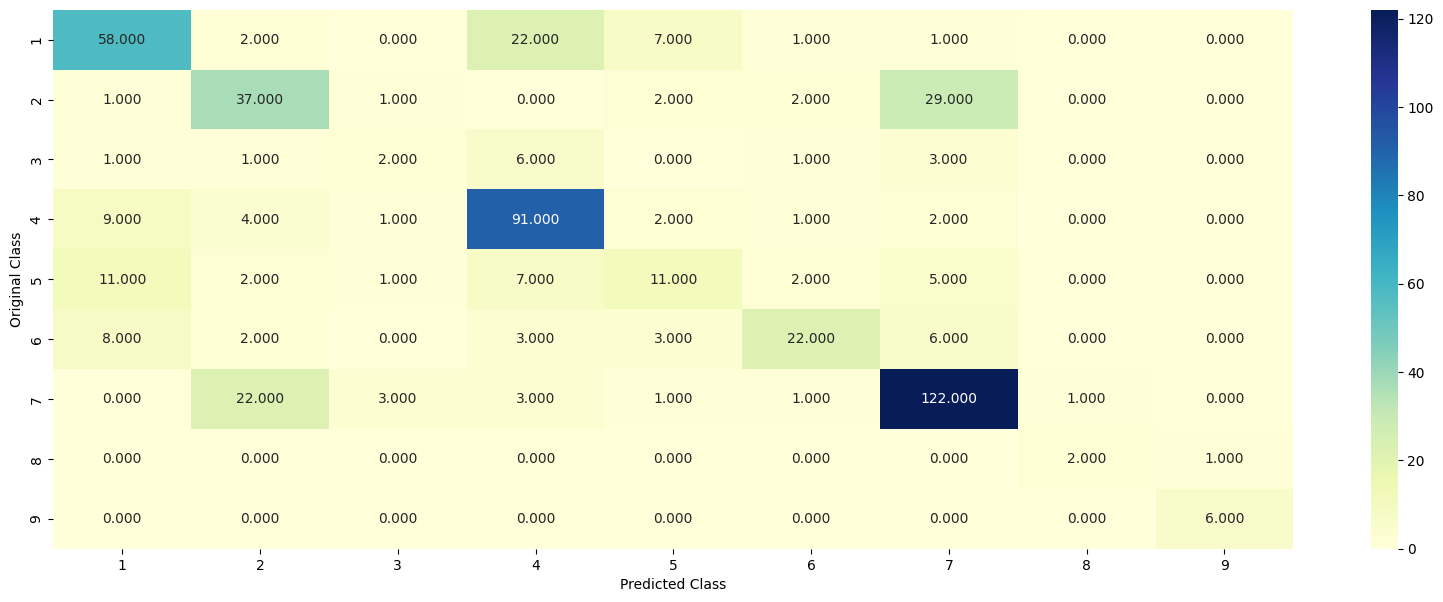

-------------------- Precision matrix (Columm Sum=1) --------------------


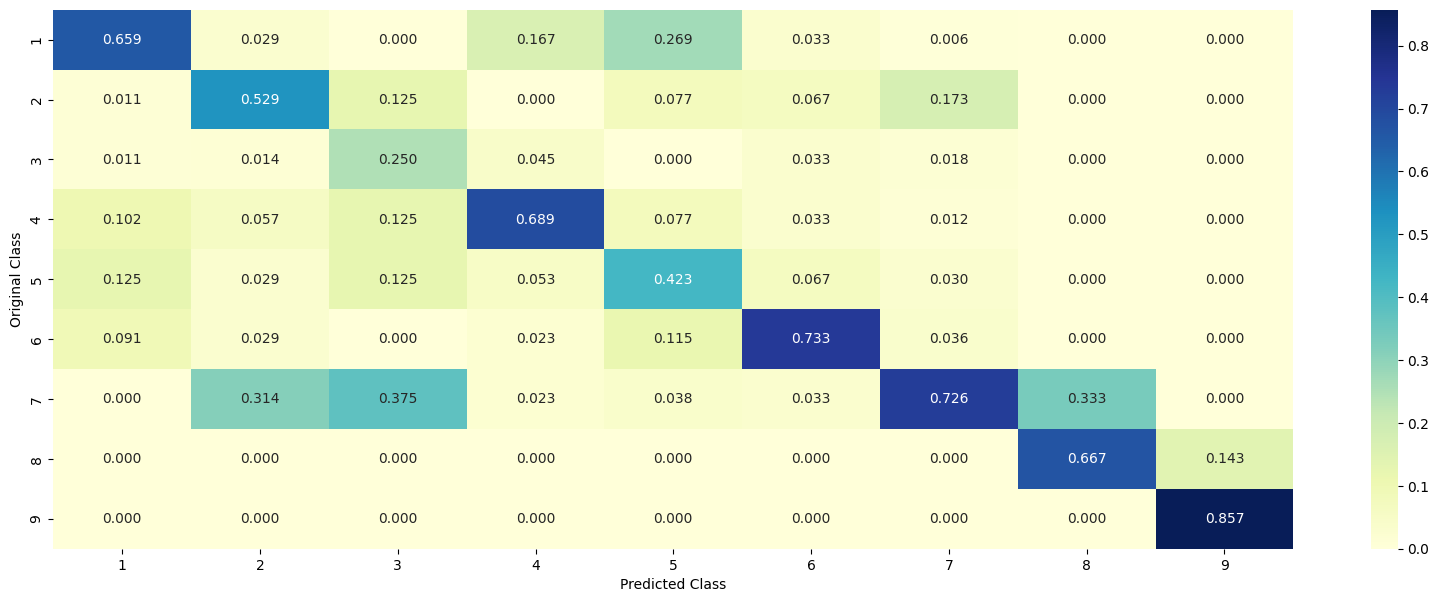

-------------------- Recall matrix (Row sum=1) --------------------


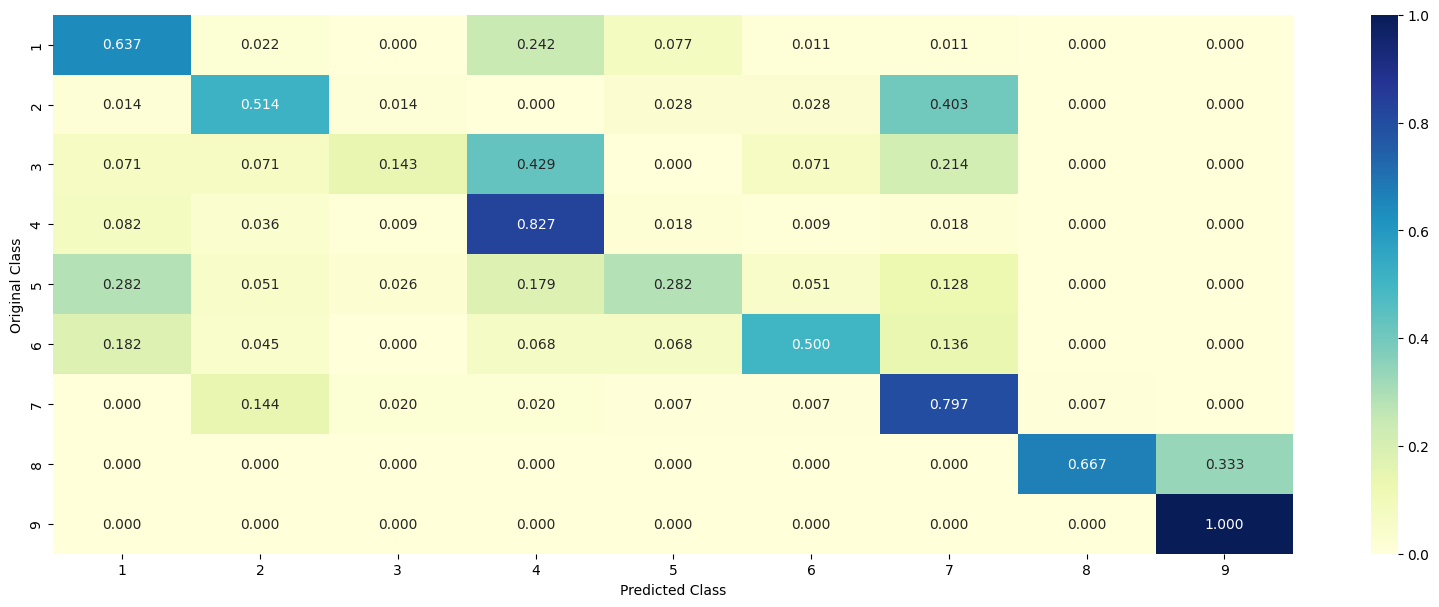

In [58]:
#Testing the model with best hyper paramters
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [59]:
#sample query point
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 1
The  5  nearest neighbours of the test points belongs to classes [1 4 1 4 1]
Fequency of nearest points : Counter({np.int64(1): 3, np.int64(4): 2})


#### 3. Logistic Regression

##### 3.1. Class balancing (though we have imbalanced classes)

In [60]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log_loss', random_state=42) #balanced
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

for alpha = 1e-06
Log Loss : 1.3254364094126945
for alpha = 1e-05
Log Loss : 1.2812223145890618
for alpha = 0.0001
Log Loss : 1.1348695956861565
for alpha = 0.001
Log Loss : 1.11807908615649
for alpha = 0.01
Log Loss : 1.2145824888930212
for alpha = 0.1
Log Loss : 1.5273020541219813
for alpha = 1
Log Loss : 1.699287435931801
for alpha = 10
Log Loss : 1.7230110463940072
for alpha = 100
Log Loss : 1.7254742944079866
For values of best alpha =  0.001 The train log loss is: 0.6033686967484264
For values of best alpha =  0.001 The cross validation log loss is: 1.11807908615649
For values of best alpha =  0.001 The test log loss is: 1.1484864652004156


Log loss : 1.11807908615649
Number of mis-classified points : 0.3383458646616541
-------------------- Confusion matrix --------------------


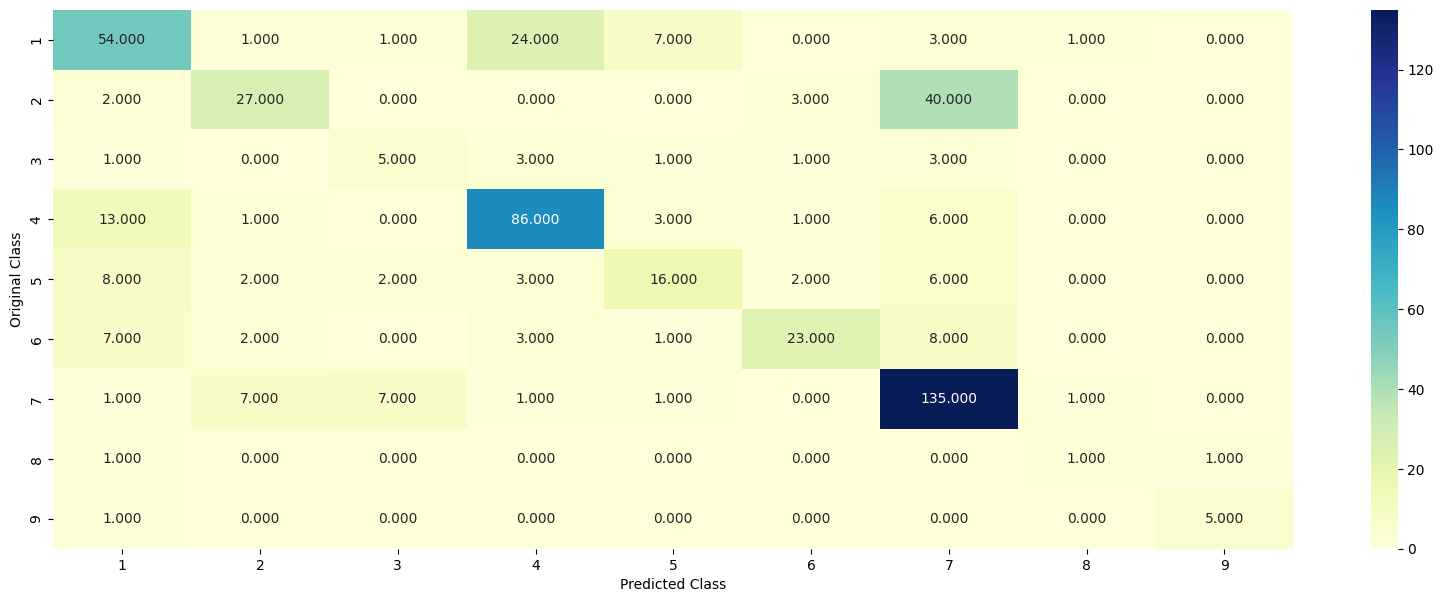

-------------------- Precision matrix (Columm Sum=1) --------------------


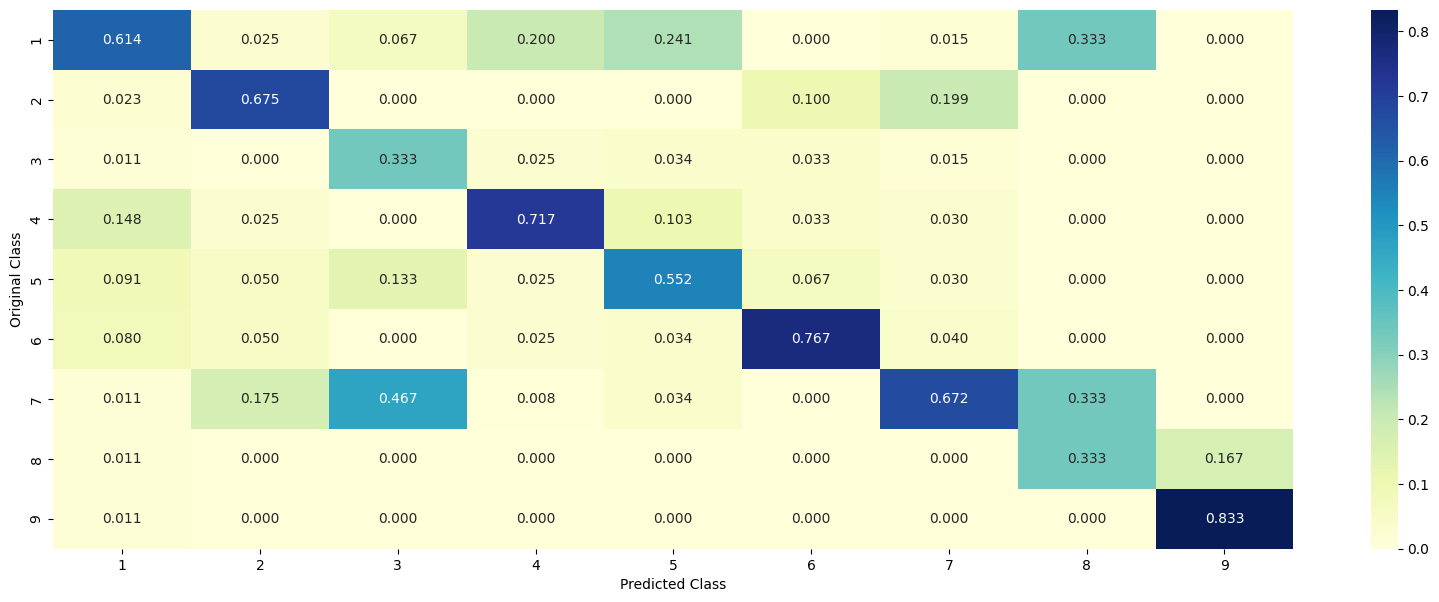

-------------------- Recall matrix (Row sum=1) --------------------


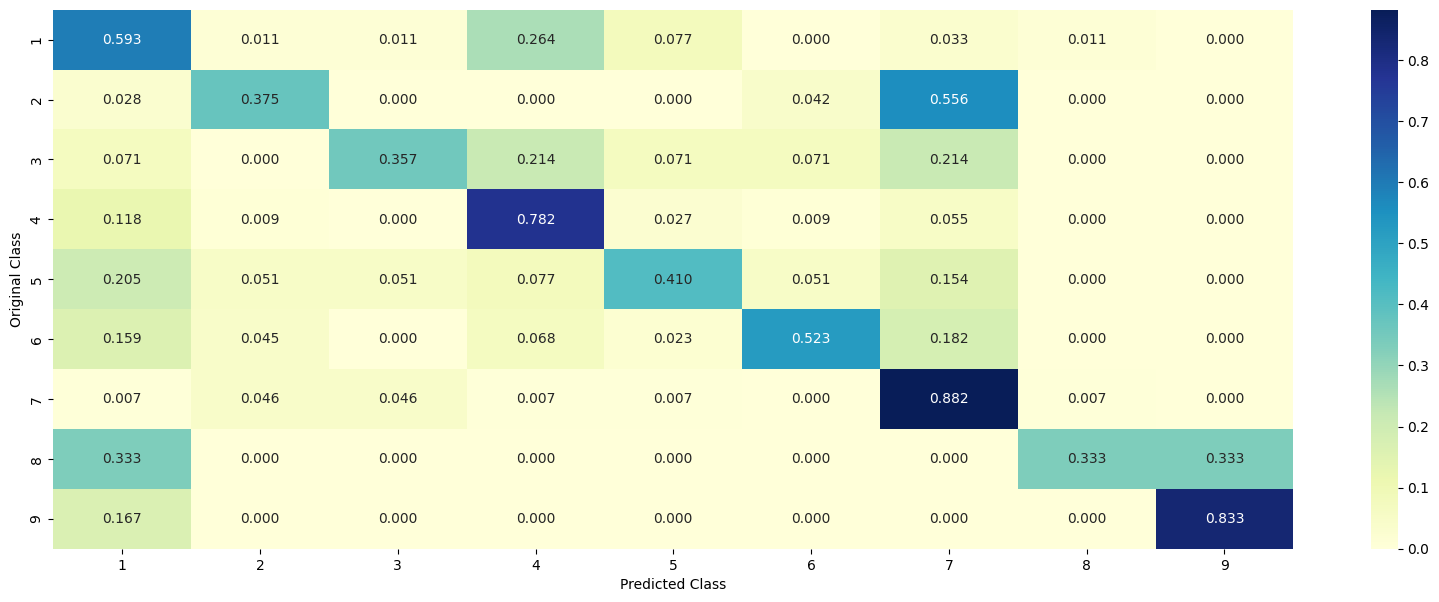

In [61]:
#Testing the model with best hyper paramters
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [62]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [63]:
# Correctly Classified point
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.276  0.1302 0.0107 0.3375 0.0556 0.0305 0.1416 0.0092 0.0087]]
Actual Class : 1
--------------------------------------------------
57 Text feature [suppressor] present in test data point [True]
212 Text feature [concentrations] present in test data point [True]
234 Text feature [novel] present in test data point [True]
Out of the top  500  features  3 are present in query point


In [64]:
# Incorrectly Classified point
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1918 0.1451 0.0414 0.2164 0.0864 0.1028 0.1966 0.0053 0.0142]]
Actual Class : 4
--------------------------------------------------
234 Text feature [novel] present in test data point [True]
Out of the top  500  features  1 are present in query point


##### 3.2. Classes without balancing

In [65]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

for alpha = 1e-06
Log Loss : 1.3159726723760314
for alpha = 1e-05
Log Loss : 1.2710447738737938
for alpha = 0.0001
Log Loss : 1.1526092426163856
for alpha = 0.001
Log Loss : 1.129283741041541
for alpha = 0.01
Log Loss : 1.232957712076947
for alpha = 0.1
Log Loss : 1.4703488805348028
for alpha = 1
Log Loss : 1.648197950153434
For values of best alpha =  0.001 The train log loss is: 0.6025973400325262
For values of best alpha =  0.001 The cross validation log loss is: 1.129283741041541
For values of best alpha =  0.001 The test log loss is: 1.1495639829988278


Log loss : 1.129283741041541
Number of mis-classified points : 0.34774436090225563
-------------------- Confusion matrix --------------------


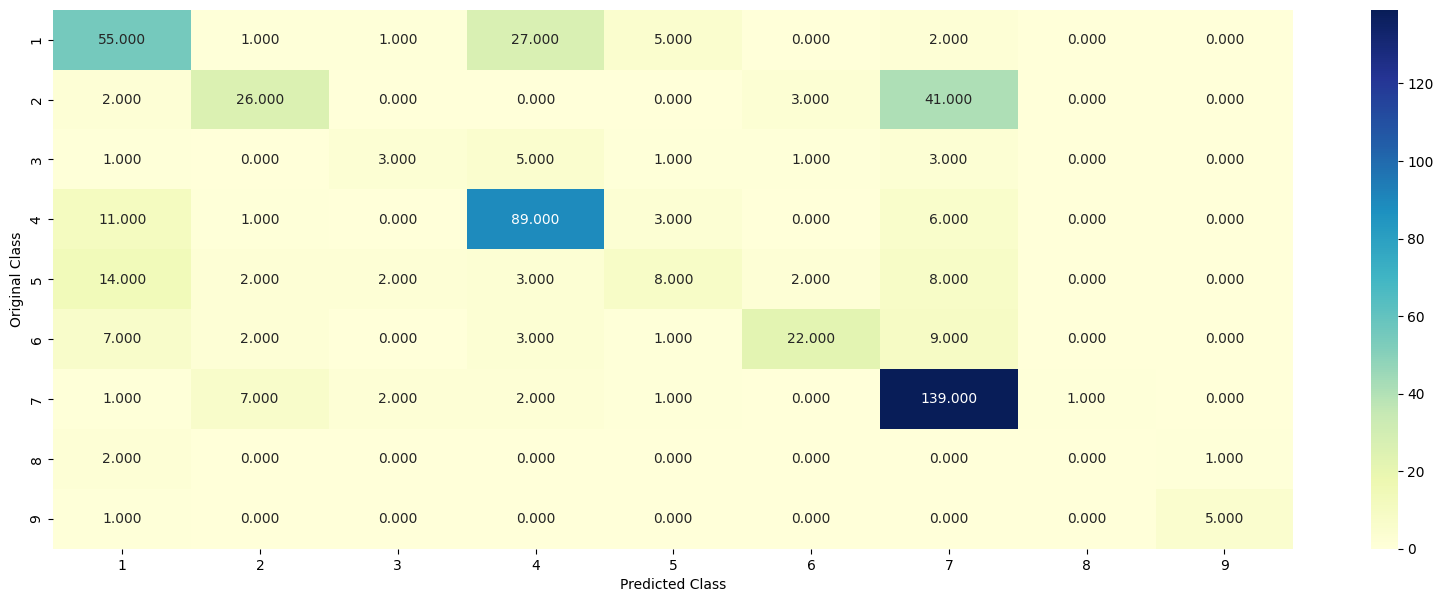

-------------------- Precision matrix (Columm Sum=1) --------------------


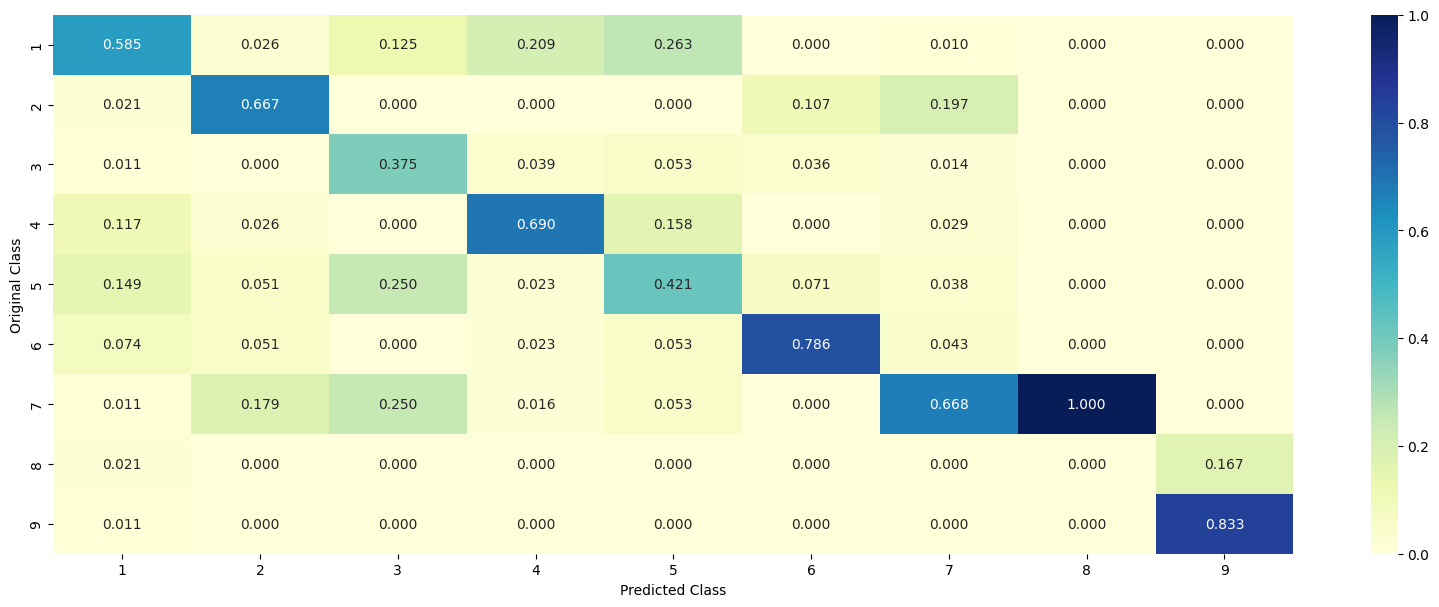

-------------------- Recall matrix (Row sum=1) --------------------


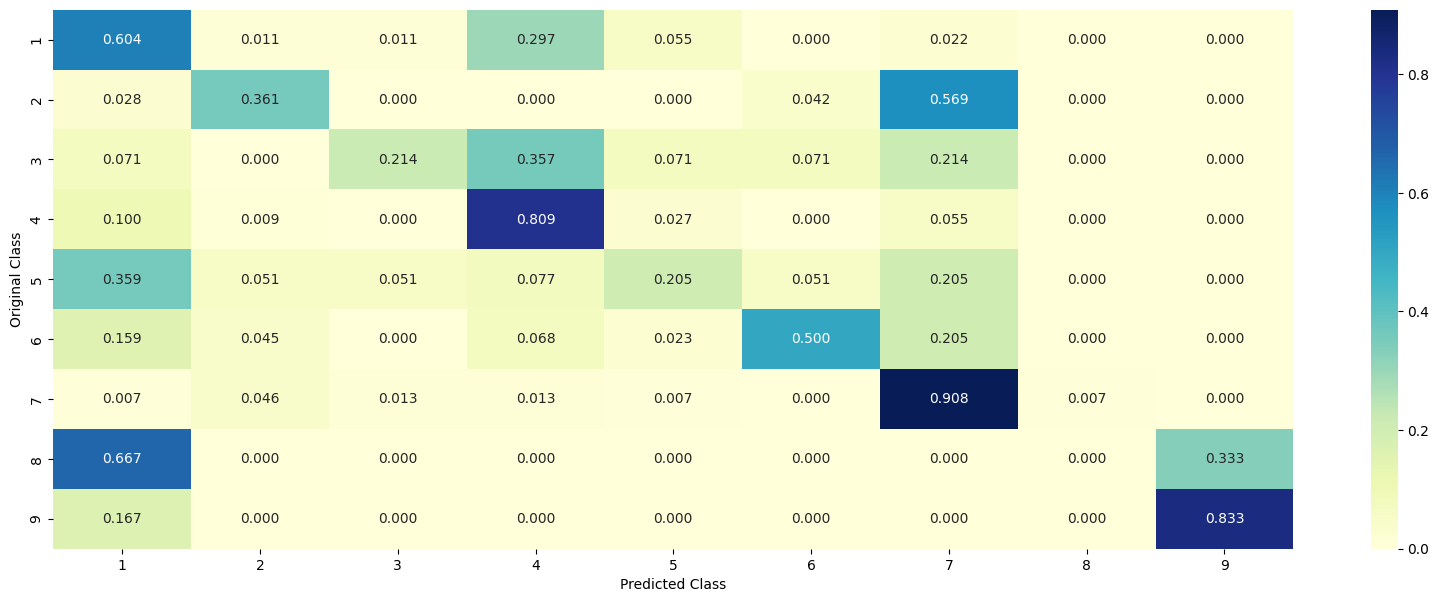

In [66]:
#Testing the model with best hyper paramters
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [67]:
# Correctly Classified point
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.2723 0.1339 0.0108 0.3418 0.0548 0.0308 0.1402 0.0097 0.0056]]
Actual Class : 1
--------------------------------------------------
116 Text feature [suppressor] present in test data point [True]
410 Text feature [concentrations] present in test data point [True]
Out of the top  500  features  2 are present in query point


In [68]:
# Incorrectly Classified point
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1849 0.1425 0.0602 0.2027 0.0965 0.1116 0.1636 0.0053 0.0328]]
Actual Class : 4
--------------------------------------------------
Out of the top  500  features  0 are present in query point


#### 4. Linear SVM

In [69]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

for C = 1e-05
Log Loss : 1.3158869573425525
for C = 0.0001
Log Loss : 1.248988335083665
for C = 0.001
Log Loss : 1.1234101393453748
for C = 0.01
Log Loss : 1.1758514058284262
for C = 0.1
Log Loss : 1.470035365264349
for C = 1
Log Loss : 1.7163186469868918
for C = 10
Log Loss : 1.7260640036943584
for C = 100
Log Loss : 1.725927913890878
For values of best alpha =  0.001 The train log loss is: 0.6170156822164795
For values of best alpha =  0.001 The cross validation log loss is: 1.1234101393453748
For values of best alpha =  0.001 The test log loss is: 1.160695230587433


Log loss : 1.1234101393453748
Number of mis-classified points : 0.33458646616541354
-------------------- Confusion matrix --------------------


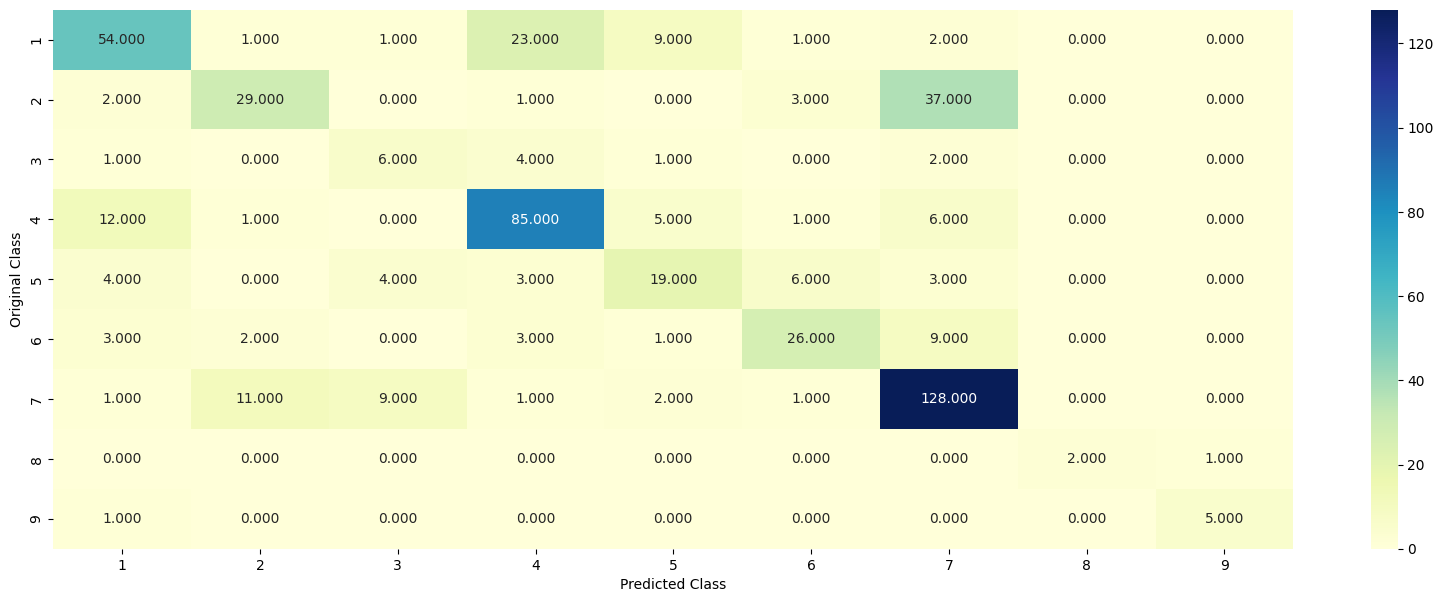

-------------------- Precision matrix (Columm Sum=1) --------------------


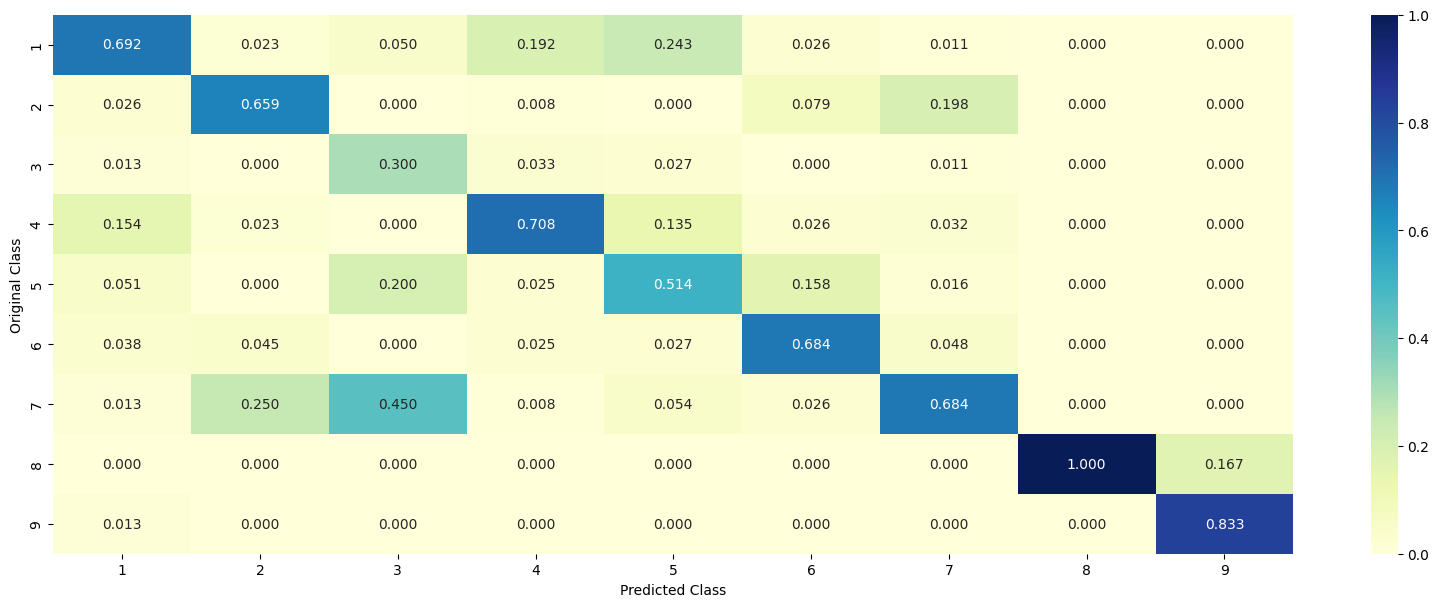

-------------------- Recall matrix (Row sum=1) --------------------


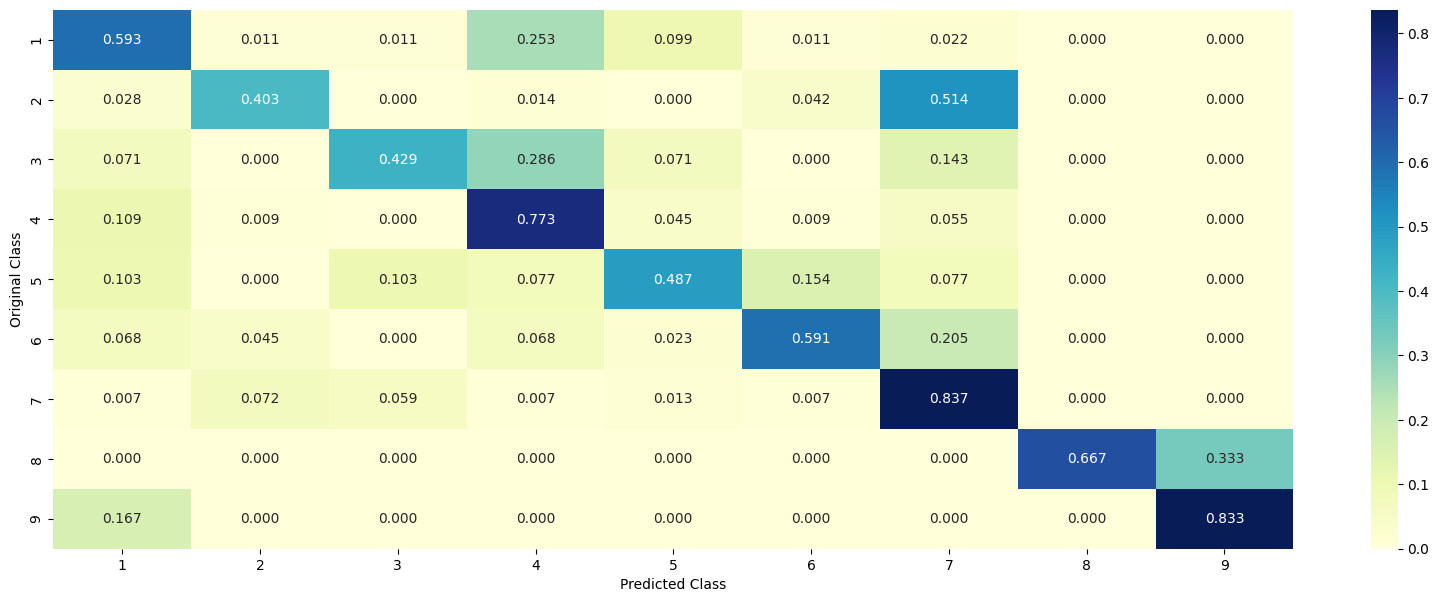

In [70]:
#Testing model with best hyper parameters
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [71]:
#For Correctly classified point
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.248  0.1448 0.0162 0.3042 0.0597 0.0334 0.1774 0.0074 0.0088]]
Actual Class : 1
--------------------------------------------------
371 Text feature [suppressor] present in test data point [True]
Out of the top  500  features  1 are present in query point


In [72]:
#For Incorrectly classified point
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1825 0.1534 0.0315 0.2638 0.0844 0.0881 0.177  0.0086 0.0107]]
Actual Class : 4
--------------------------------------------------
283 Text feature [deciding] present in test data point [True]
Out of the top  500  features  1 are present in query point


#### 5.1. Random Forest Classifier (With One hot Encoding)

In [73]:
alpha = [100,200,500]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2100083211798116
for n_estimators = 100 and max depth =  10
Log Loss : 1.1461445111104778
for n_estimators = 200 and max depth =  5
Log Loss : 1.2032331517113817
for n_estimators = 200 and max depth =  10
Log Loss : 1.1418851439509325
for n_estimators = 500 and max depth =  5
Log Loss : 1.1982772566479545
for n_estimators = 500 and max depth =  10
Log Loss : 1.1366912478891342
For values of best estimator =  500 The train log loss is: 0.6970153631822055
For values of best estimator =  500 The cross validation log loss is: 1.1366912478891342
For values of best estimator =  500 The test log loss is: 1.1249645192309716


Log loss : 1.1366912478891342
Number of mis-classified points : 0.37406015037593987
-------------------- Confusion matrix --------------------


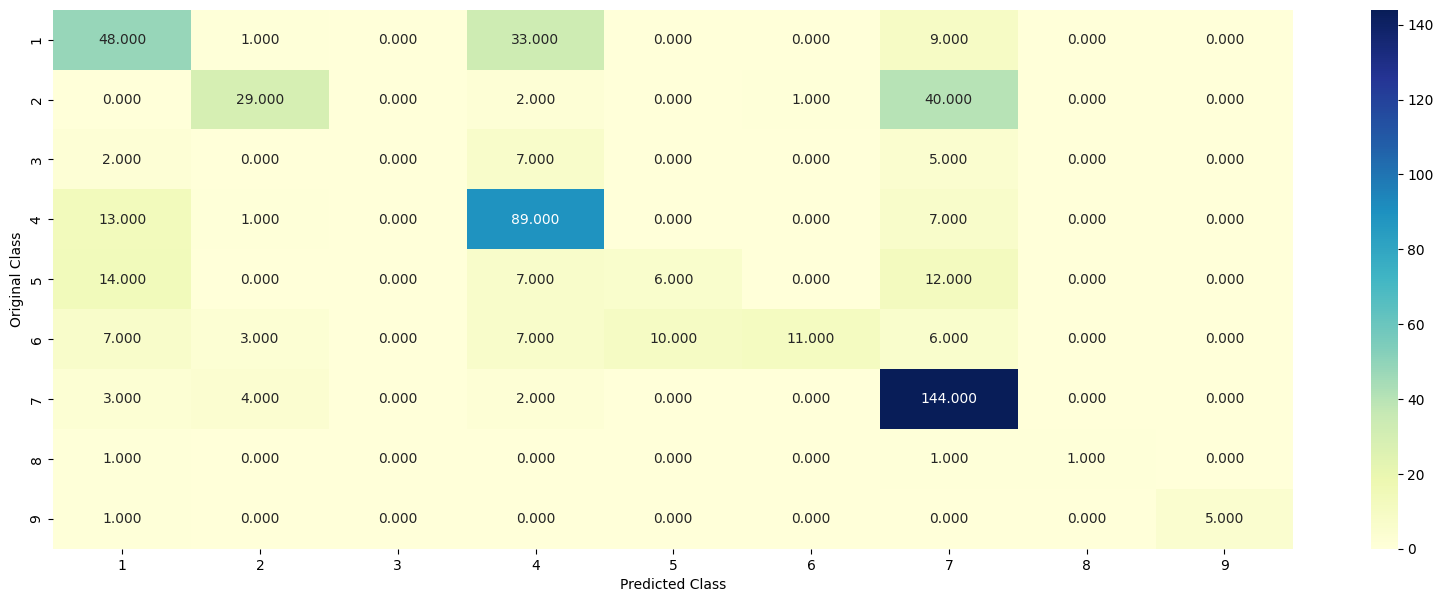

-------------------- Precision matrix (Columm Sum=1) --------------------


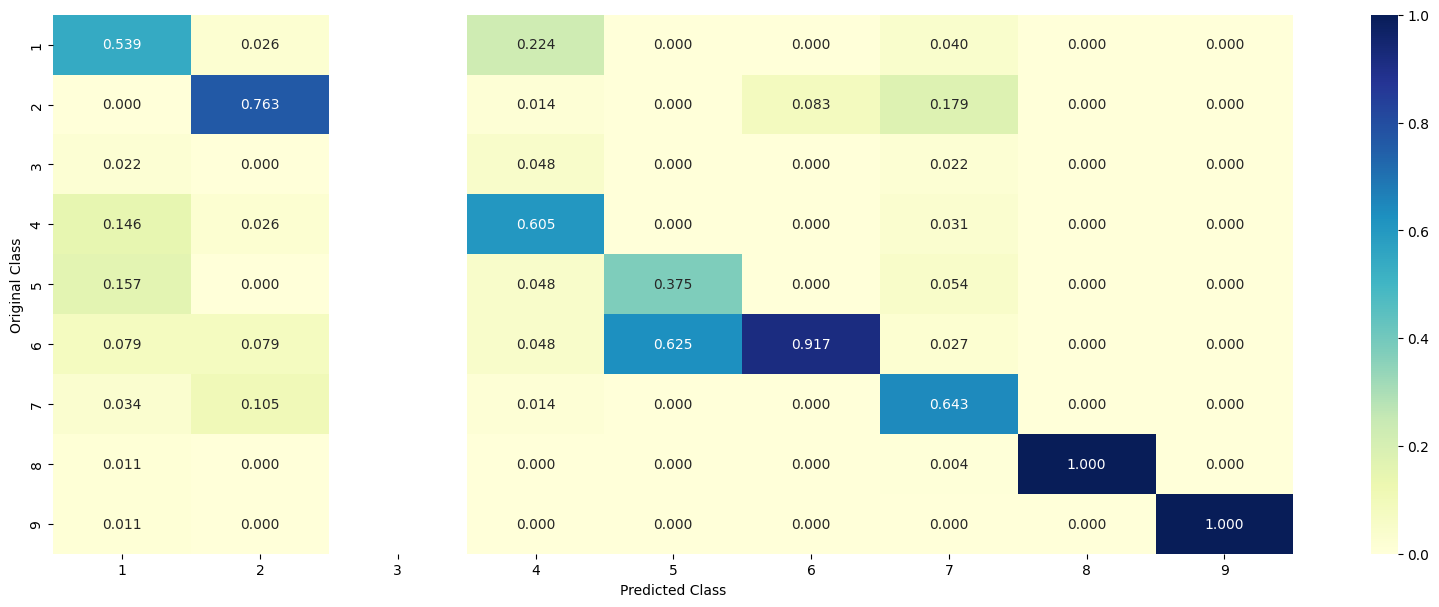

-------------------- Recall matrix (Row sum=1) --------------------


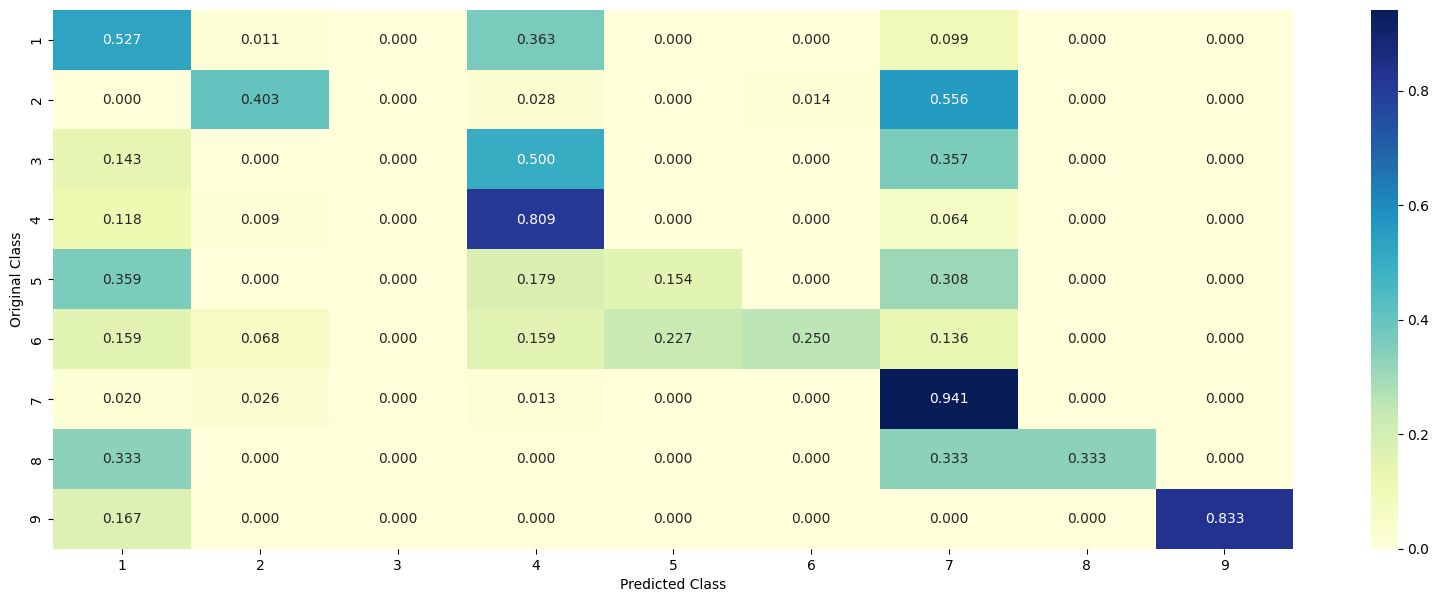

In [74]:
#Testing model with best hyper parameters 
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,y_cv, clf)

In [75]:
# Correctly Classified point
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.2969 0.0669 0.0204 0.4067 0.0631 0.0498 0.0787 0.0073 0.0103]]
Actual Class : 1
--------------------------------------------------
3 Text feature [activation] present in test data point [True]
9 Text feature [constitutive] present in test data point [True]
12 Text feature [suppressor] present in test data point [True]
13 Text feature [function] present in test data point [True]
17 Text feature [loss] present in test data point [True]
18 Text feature [missense] present in test data point [True]
19 Text feature [cells] present in test data point [True]
21 Text feature [yeast] present in test data point [True]
27 Text feature [functional] present in test data point [True]
28 Text feature [growth] present in test data point [True]
29 Text feature [deleterious] present in test data point [True]
30 Text feature [downstream] present in test data point [True]
35 Text feature [therapy] present in test data point [True]
37 Text feature [dna]

In [76]:
# Inorrectly Classified point
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.231  0.1214 0.023  0.3855 0.0686 0.0648 0.0853 0.008  0.0125]]
Actuall Class : 4
--------------------------------------------------
18 Text feature [missense] present in test data point [True]
19 Text feature [cells] present in test data point [True]
27 Text feature [functional] present in test data point [True]
31 Text feature [pathogenic] present in test data point [True]
39 Text feature [cell] present in test data point [True]
49 Text feature [variants] present in test data point [True]
64 Text feature [variant] present in test data point [True]
85 Text feature [protein] present in test data point [True]
Out of the top  100  features  8 are present in query point


#### 5.2. Random Forest Classifier (With Response coding)

In [77]:
alpha = [50,100,200,500]
max_depth = [3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y))

for n_estimators = 50 and max depth =  3
Log Loss : 1.4079778292031089
for n_estimators = 50 and max depth =  5
Log Loss : 1.3316239616787469
for n_estimators = 50 and max depth =  10
Log Loss : 1.739714959950799
for n_estimators = 100 and max depth =  3
Log Loss : 1.4351626835253821
for n_estimators = 100 and max depth =  5
Log Loss : 1.3482351993932968
for n_estimators = 100 and max depth =  10
Log Loss : 1.7397420371008048
for n_estimators = 200 and max depth =  3
Log Loss : 1.4261963850020023
for n_estimators = 200 and max depth =  5
Log Loss : 1.402467252409209
for n_estimators = 200 and max depth =  10
Log Loss : 1.7303038229874392
for n_estimators = 500 and max depth =  3
Log Loss : 1.4272374917708628
for n_estimators = 500 and max depth =  5
Log Loss : 1.4122598677771598
for n_estimators = 500 and max depth =  10
Log Loss : 1.7306402915605892
For values of best alpha =  50 The train log loss is: 0.07655343492151784
For values of best alpha =  50 The cross validation log loss is

Log loss : 1.3316239616787469
Number of mis-classified points : 0.4868421052631579
-------------------- Confusion matrix --------------------


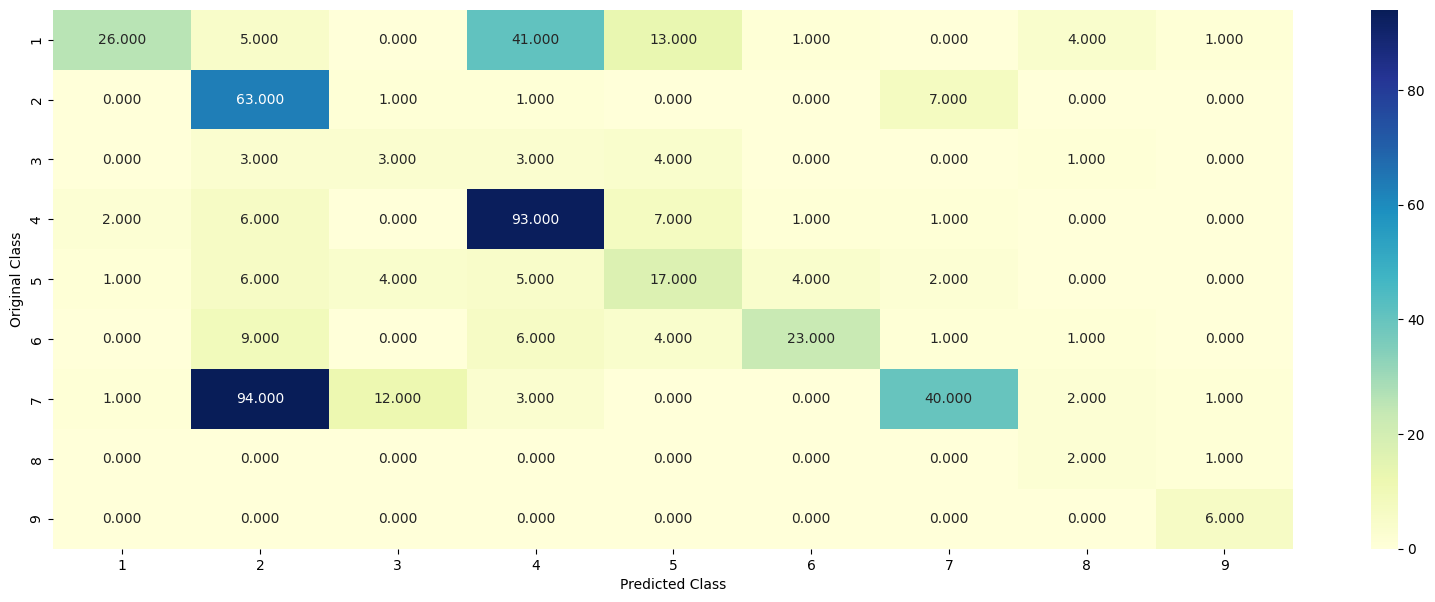

-------------------- Precision matrix (Columm Sum=1) --------------------


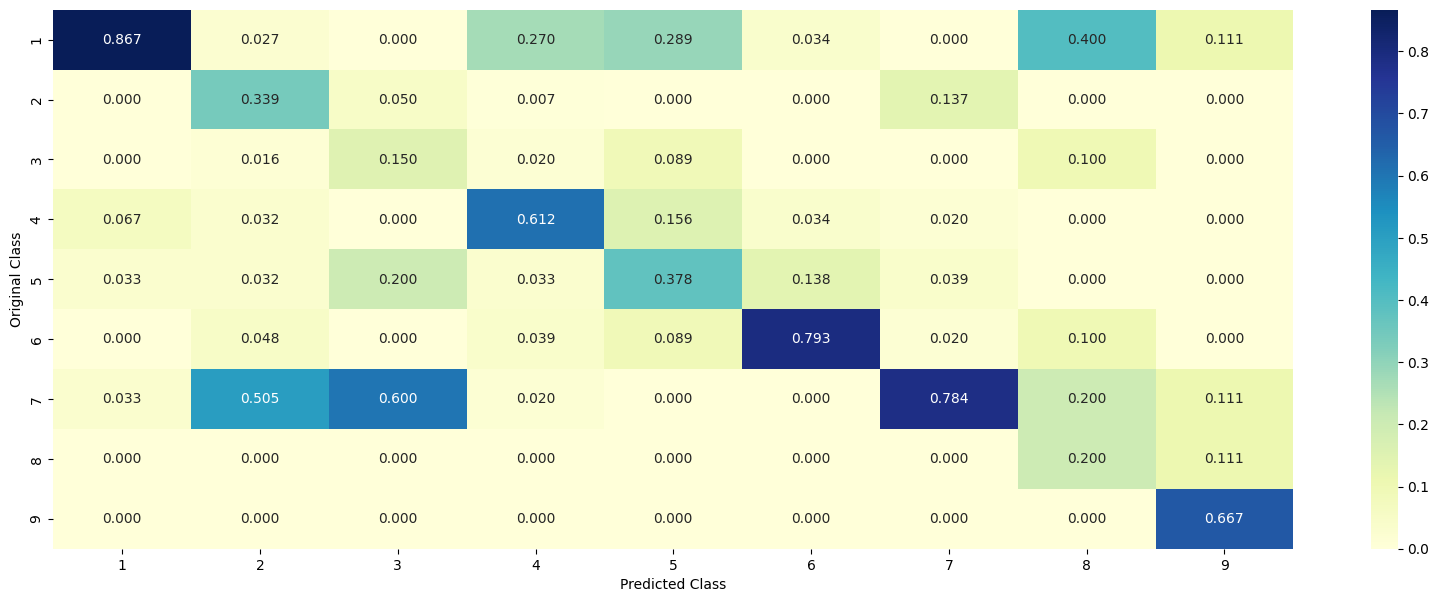

-------------------- Recall matrix (Row sum=1) --------------------


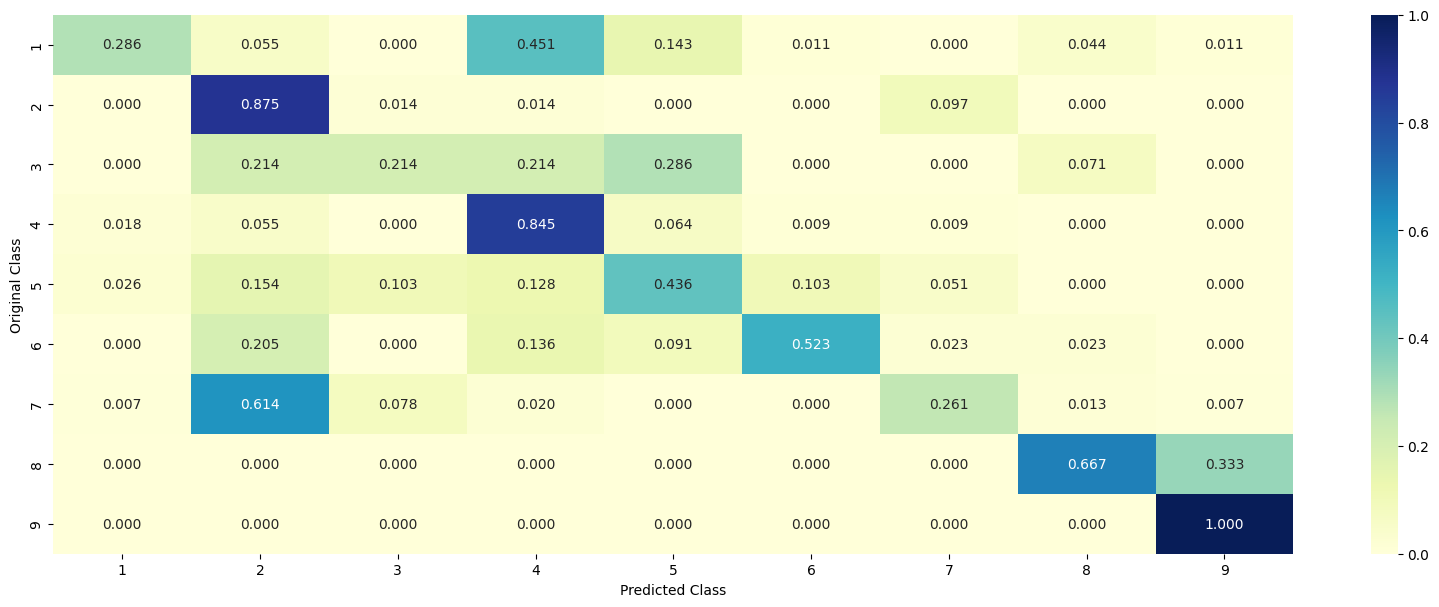

In [78]:
#Testing model with best hyper parameters
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

In [79]:
# Correctly Classified point
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 4
Predicted Class Probabilities: [[0.1373 0.0351 0.1103 0.5431 0.0384 0.0656 0.008  0.0247 0.0374]]
Actual Class : 1
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature


In [80]:
# Incorrectly Classified point
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 4
Predicted Class Probabilities: [[0.1785 0.0389 0.1017 0.51   0.0398 0.0444 0.0083 0.0307 0.0476]]
Actual Class : 4
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature


### Stacking Classifier

In [81]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log_loss', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

clf4 = KNeighborsClassifier(n_neighbors=11)
clf4.fit(train_x_onehotCoding,train_y)
sig_clf4 = CalibratedClassifierCV(clf4, method="sigmoid")

clf5 = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=250, random_state=42, n_jobs=-1)
clf5.fit(train_x_onehotCoding,train_y)
sig_clf5 = CalibratedClassifierCV(clf5, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
sig_clf4.fit(train_x_onehotCoding, train_y)
print("K Nearest Neighbour : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf4.predict_proba(cv_x_onehotCoding))))
sig_clf5.fit(train_x_onehotCoding, train_y)
print("Random Forest : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf5.predict_proba(cv_x_onehotCoding))))

Logistic Regression :  Log Loss: 1.12
Support vector machines : Log Loss: 1.72
Naive Bayes : Log Loss: 1.23
K Nearest Neighbour : Log Loss: 1.35
Random Forest : Log Loss: 1.17


In [82]:
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(estimators=[('clf1', clf1), ('clf2', clf2),('clf3',clf3)], final_estimator=lr)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.815
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.700
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.323
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.064
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.015
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.043


Log loss (train) on the stacking classifier : 0.5576740544945658
Log loss (CV) on the stacking classifier : 1.014647669844938
Log loss (test) on the stacking classifier : 1.0864235378581626
Number of missclassified point : 0.3819548872180451
-------------------- Confusion matrix --------------------


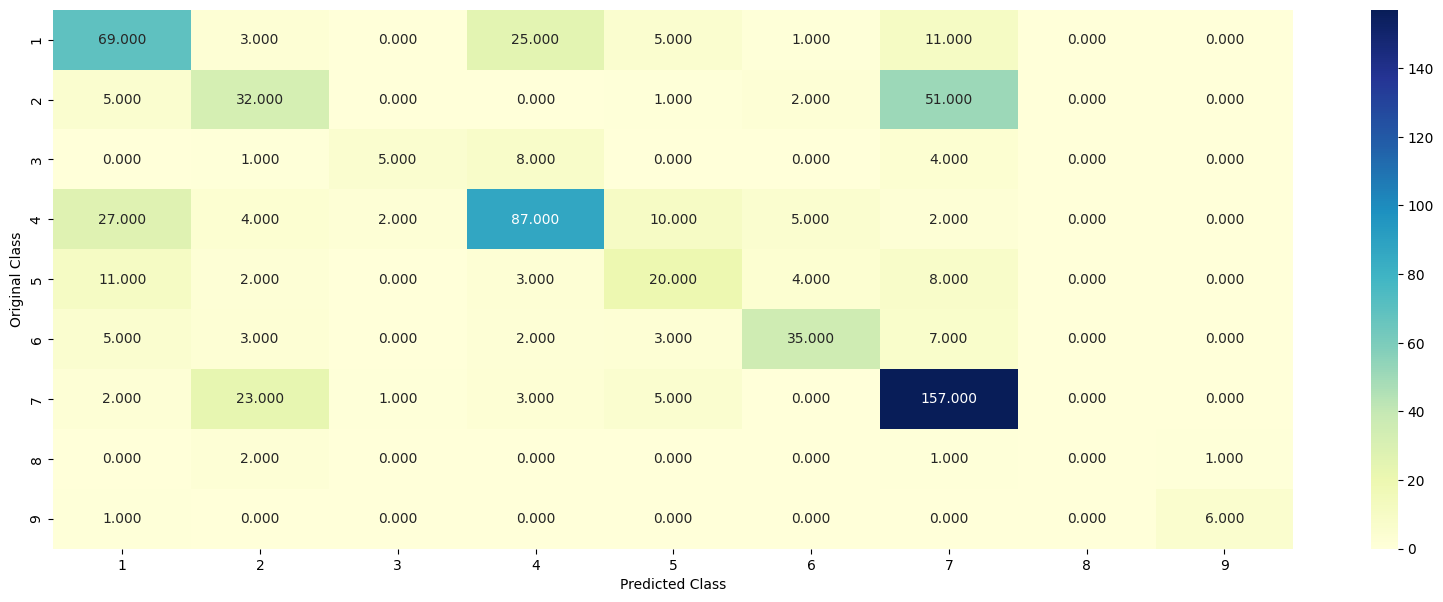

-------------------- Precision matrix (Columm Sum=1) --------------------


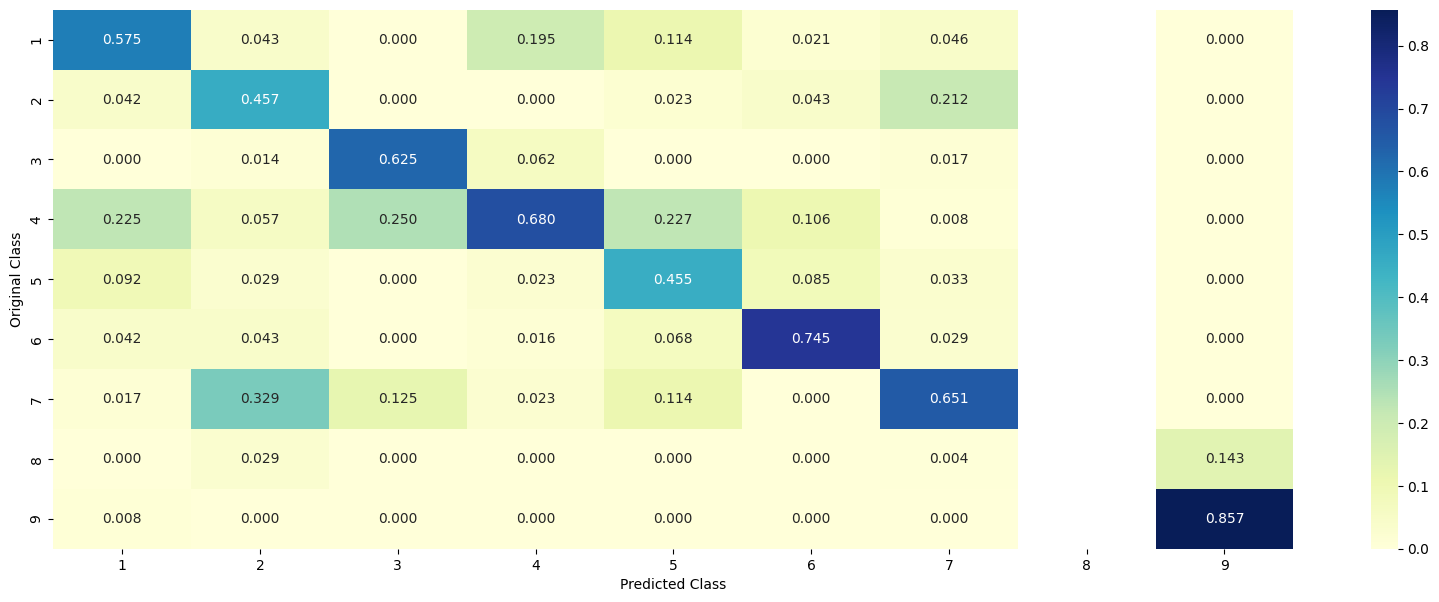

-------------------- Recall matrix (Row sum=1) --------------------


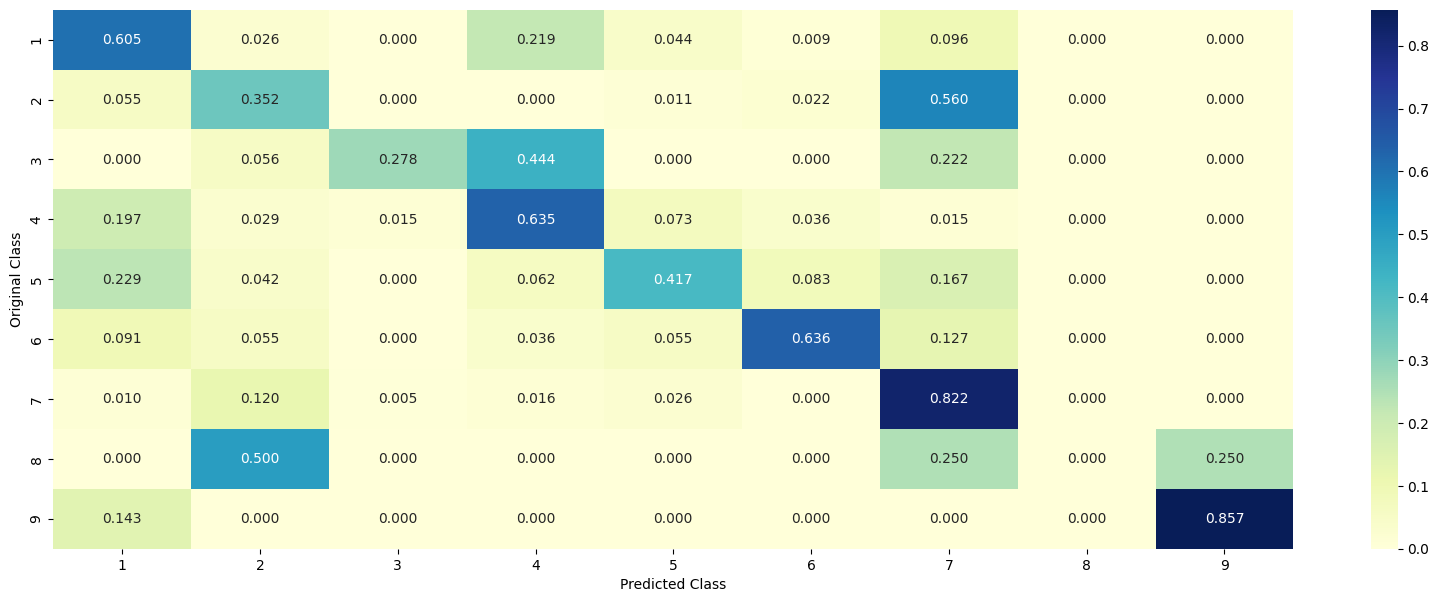

In [83]:
# testing the model with the best hyper parameters
lr = LogisticRegression(C=1.0)
sclf = StackingClassifier(estimators=[('clf1', clf1), ('clf2', clf2),('clf3',clf3)], final_estimator=lr)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

In [84]:
#preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('gene', TfidfVectorizer(), 'Gene'),
        ('variation', TfidfVectorizer(), 'Variation'),
        ('text', TfidfVectorizer(max_features=10000), 'TEXT')
    ]
)

In [85]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', sclf)
])

pipeline.fit(train_df, y_train)
y_pred = pipeline.predict(cv_df)
print(classification_report(y_cv, y_pred))

              precision    recall  f1-score   support

           1       0.66      0.65      0.66        91
           2       0.67      0.40      0.50        72
           3       0.00      0.00      0.00        14
           4       0.73      0.80      0.77       110
           5       0.48      0.41      0.44        39
           6       0.82      0.52      0.64        44
           7       0.68      0.93      0.79       153
           8       0.00      0.00      0.00         3
           9       0.75      1.00      0.86         6

    accuracy                           0.68       532
   macro avg       0.53      0.52      0.52       532
weighted avg       0.66      0.68      0.66       532

